<a href="https://colab.research.google.com/github/jsong55/Machine_Learning/blob/master/04_transfer_learning_in_tensorflow_part1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning part 1: Feature extraction

Benefits of TL:
1. Can leverage an existing neural network architecture proven to work with similar problems
2. Can leverage a working NN architecture which has already learning on similar data

In [1]:
import zipfile
import os
import random
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential, layers
import datetime
import tensorflow_hub as hub

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip","r")
zip_ref.extractall()
zip_ref.close()

--2022-10-18 17:36:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  54.4MB/s    in 3.0s    

2022-10-18 17:36:49 (54.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

## create data loaders (preparing the data)
use ImageDataGenerator class to load images in batches


In [4]:
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

# Setup the train and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"
# rescale
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                              target_size=IMAGE_SHAPE,
                              batch_size=BATCH_SIZE,
                              class_mode='categorical',
                              shuffle=True)

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                        target_size=IMAGE_SHAPE,
                        batch_size=BATCH_SIZE,
                        class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while our model trains)

Callbacks are extra functionality you can add to your models to be performed during of after trainng. Some popular callbacks are:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create TensorBoard callback (for multiple models)
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using Tensorflow hub

We can access pretrained models on : https://tfhub.dev/

Check out https://paperswithcode.com

In [6]:
# Let's compare 2 models from tfhub
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
# Let's make a function to create a model from a url
def create_model(model_url,num_classes=10):
  """
  Takes a TensoeFlow HUB URL and creates a Keras Sequential model with it.

  Args:
  model_url(str): A Tensorflow hub feature extraction url
  num_classes(int): number of output neurons in the output layers, should
    be equal to the number of target classes

  Returns:
    An uncompiled keras sequential model with model_url as feature extractor layers and 
      dense output layer with num_class output neurons.
  """
  # Download the pretrained model and save it as a keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                        trainable=False,
                        name="feature_extraction_layer",
                        input_shape=IMAGE_SHAPE+(3,)) # freeze the already learned patterns

  # Create our model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])                  
  return model


## Create Resnet Tensorflow hub feature extraction model

In [10]:
# Create model
resnet_model = create_model(resnet_url,
              num_classes=train_data_10_percent.num_classes)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [15]:
# compile the model
resnet_model.compile(loss = "categorical_crossentropy",
          optimizer = Adam(),
          metrics = ["accuracy"])

In [16]:
history_1 = resnet_model.fit(train_data_10_percent,
              epochs=5,
              steps_per_epoch=len(train_data_10_percent),
              validation_data=test_data,
              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                  experiment_name="resnet50V2")],
              validation_steps=len(test_data))

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221018-174621
Epoch 1/5
24/24 [==============================] - 29s 749ms/step - loss: 1.9372 - accuracy: 0.3720 - val_loss: 1.2021 - val_accuracy: 0.6280
Epoch 2/5
24/24 [==============================] - 16s 677ms/step - loss: 0.9180 - accuracy: 0.7387 - val_loss: 0.8711 - val_accuracy: 0.7276
Epoch 3/5
24/24 [==============================] - 16s 676ms/step - loss: 0.6403 - accuracy: 0.8133 - val_loss: 0.7454 - val_accuracy: 0.7640
Epoch 4/5
24/24 [==============================] - 16s 674ms/step - loss: 0.4857 - accuracy: 0.8587 - val_loss: 0.7100 - val_accuracy: 0.7688
Epoch 5/5
24/24 [==============================] - 16s 678ms/step - loss: 0.3885 - accuracy: 0.8973 - val_loss: 0.6679 - val_accuracy: 0.7876


In [17]:
def plot_loss_curves(history):
  """
  Return separate loss curves for training and validation metrics
  """
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]
  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]
  epochs=range(len(history.history["loss"]))

  # plot loss
  plt.figure()
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

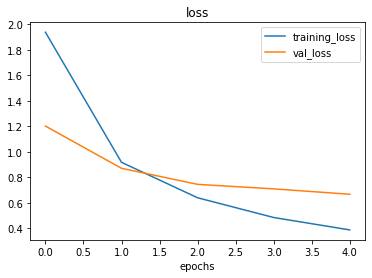

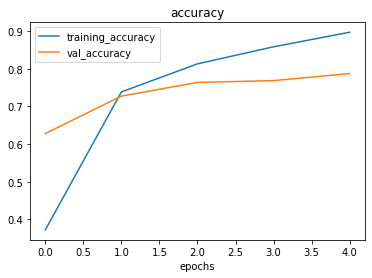

In [18]:
plot_loss_curves(history_1)

## Create EfficientnetB0 Tensorflow hub feature extraction model

In [19]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
# compile the model
efficientnet_model.compile(loss = "categorical_crossentropy",
          optimizer = Adam(),
          metrics = ["accuracy"])

efficient_history = efficientnet_model.fit(train_data_10_percent,
              epochs=5,
              steps_per_epoch=len(train_data_10_percent),
              validation_data=test_data,
              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                  experiment_name="efficientnetb0")],
              validation_steps=len(test_data))

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20221018-184753
Epoch 1/5
24/24 [==============================] - 26s 750ms/step - loss: 1.8754 - accuracy: 0.4213 - val_loss: 1.3461 - val_accuracy: 0.7128
Epoch 2/5
24/24 [==============================] - 15s 664ms/step - loss: 1.0741 - accuracy: 0.7627 - val_loss: 0.8882 - val_accuracy: 0.8176
Epoch 3/5
24/24 [==============================] - 15s 662ms/step - loss: 0.7632 - accuracy: 0.8320 - val_loss: 0.7114 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 16s 670ms/step - loss: 0.6089 - accuracy: 0.8693 - val_loss: 0.6185 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 16s 671ms/step - loss: 0.5126 - accuracy: 0.8920 - val_loss: 0.5654 - val_accuracy: 0.8624


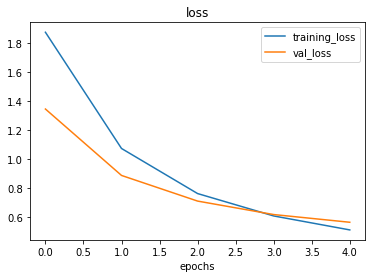

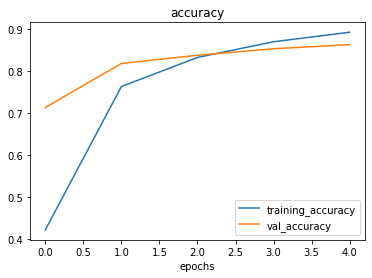

In [20]:
plot_loss_curves(efficient_history)

## Different types of transfer learning

* "As is" transfer learning - using an existing model with no changes what so ever
* "Feature extraction" - use the pretrained patterns of an existing model (e.g. EfficientNetB0/Resnet) and adjust the output layer for your own problem
* "Fine-tuning" Transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

In [23]:
# the number of layers of efficientnetb0
len(efficientnet_model.layers[0].weights)

309

## Compare model results using tensorboard

When upload to Tensorboard.dev, your experiments are public

In [24]:
# Upload tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "EfficientNetB0 vx. ResNet50V2" \
 --description "Comparing two different TF Hub feature extraction model architecture using 10% of the training data" \
 --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=g3RZeZzOuanEtdanShRMsTarHFHTGF&prompt=consent&access_type=off

In [25]:
# tensorboard experiments are uploaded publically : https://tensorboard.dev/experiment/TQyXix7JQcK3zgXf6peoJQ/

# check out what tensor experiments I have
!tensorboard dev list

https://tensorboard.dev/experiment/TQyXix7JQcK3zgXf6peoJQ/
	Name                 EfficientNetB0 vx. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the training data
	Id                   TQyXix7JQcK3zgXf6peoJQ
	Created              2022-10-18 21:09:38 (17 minutes ago)
	Updated              2022-10-18 21:09:43 (16 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918715
Total: 1 experiment(s)


In [ ]:
# delete an experiment
#!tensorboard dev delete --experimennt_id TQyXix7JQcK3zgXf6peoJQ